In [1]:
#Load in required packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy

import sys
import glob
import os

#For converting between geolocal and numerical ages
from pyrolite.util.time import Timescale

sys.path.insert(1, '../pygplates_rev28_python37_win64')
import pygplates
import ptt

import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#For plotting histograms
from itertools import combinations

In [23]:
df=pd.read_csv("petlab_withgrids.csv")
df

,Sample_ID,Collection,Coll_No,Plot_unit,Feature_Type,Feature_Name,Top_Depth,Bottom_Depth,Field_Number,Collection_Date,...,gridsed,gridsubsed,gridserp,gridsubserp,gridslabage,gridslabdip,gridslabthick,gridslabvel,gridslabsubage,gridslabtop
0,32257,GNS P (P),40894,Whakaari,Surface,NaN,NaN,NaN,NaN,1981-01-01 00:00:00,...,0.000046,0.000000,0.0,0.000000,0.00000,0.00000,0.000,0.000000,26.414402,NaN
1,125909,GNS P (P),79818,Arc,Surface,NaN,NaN,NaN,LS1,40220,...,0.000006,0.000039,0.0,0.000718,32.78672,22.01977,225093.375,0.000875,26.285441,NaN
2,169088,other,RVAN-17-13.1,Arc,Dredge,Nesmeyanov-N17-13,NaN,NaN,NaN,NaN,...,0.000046,0.000005,0.0,0.000003,0.00000,0.00000,0.000,0.000000,25.345132,NaN
3,106981,other,BFH-MP112,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,0.000129,0.000072,0.0,0.000003,0.00000,0.00000,0.000,0.000000,39.000000,NaN
4,107013,other,BFH-MP279,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,0.000129,0.000072,0.0,0.000003,0.00000,0.00000,0.000,0.000000,39.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,109562,other,87-144A,Continent basement,Dredge,Sonne 36-57,2400,2700,unknown,1994-01-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
968,64286,GNS P (P),73035,Continent basement,Drillcore,ODP-824C,411.92,NaN,"133-824C-18R-1,42-45",32973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
969,44824,GNS P (P),57235,Austral,Drillcore,Pakaha-1,3360,3363,Pakaha,28126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
970,44823,GNS P (P),57234,Austral,Drillcore,Parara-1,3799,3802,Parara,27760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Check column names
#print(df.columns.tolist())

#Check column types
#print(df.dtypes.tolist())

In [136]:
#Load in the dataset representing "background" noise (PICK 1)

#Based on randomised ages
#dfneg=pd.read_csv("petlab_withgrids_neg_age.csv")

#Based on randomised locations
dfneg=pd.read_csv("petlab_withgrids_neg_loc.csv")


In [137]:
#Many of the grids are sampled with 0.0 when in fact there is no data there. 
#Replace these 0.0 values with nans
df.replace(to_replace=0.0, value=np.nan, inplace=True)
dfneg.replace(to_replace=0.0, value=np.nan, inplace=True)

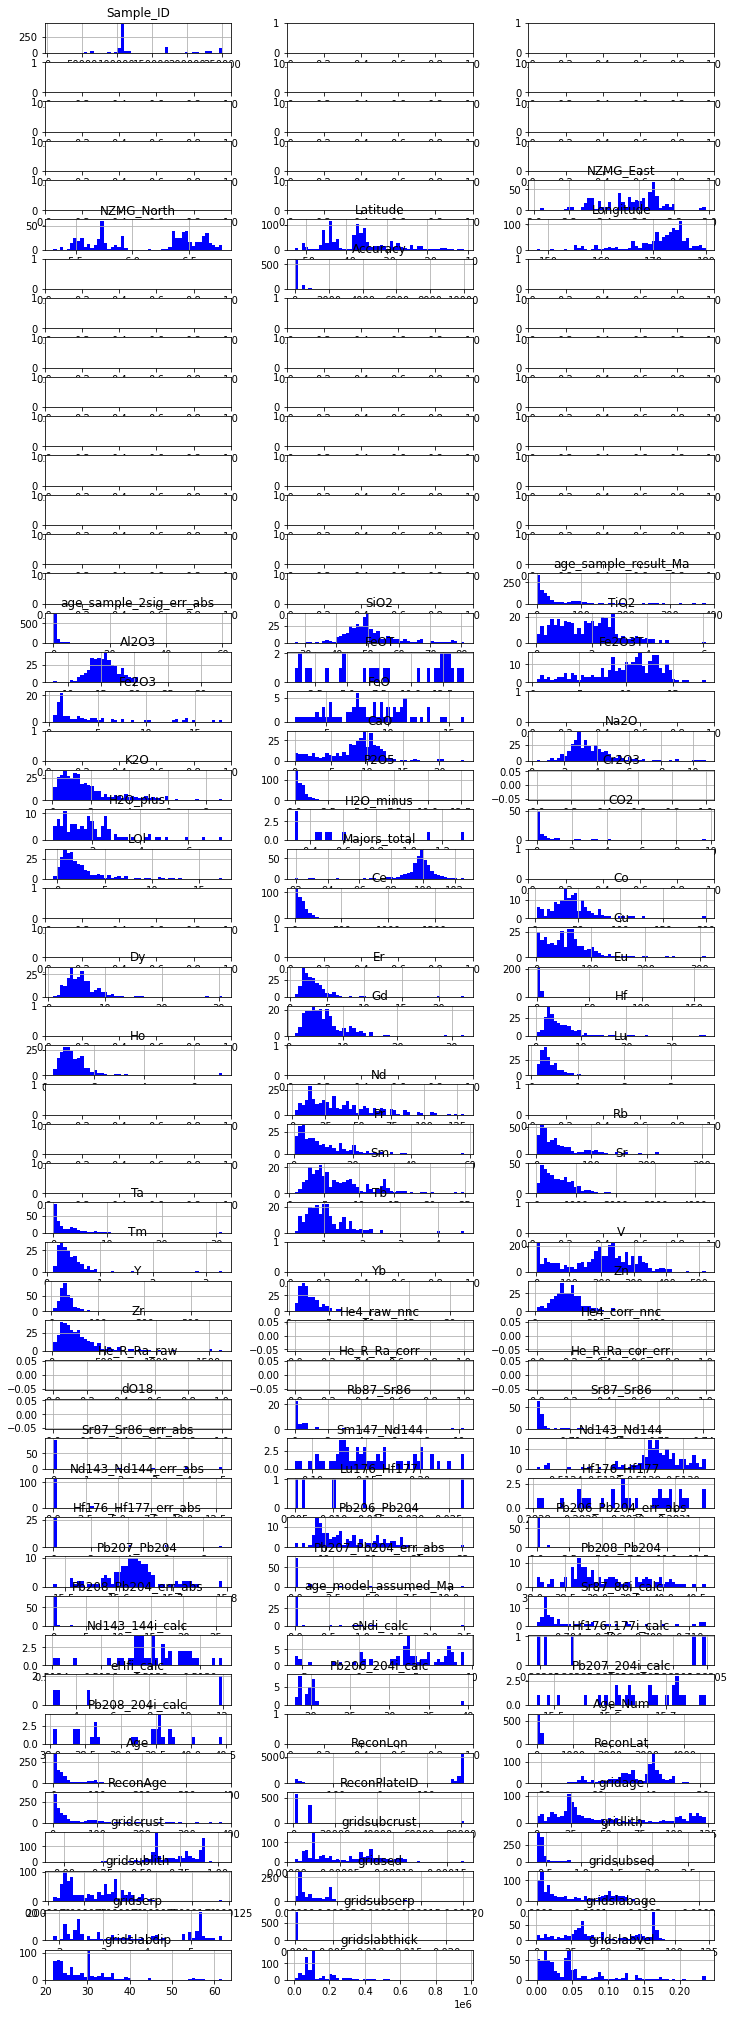

In [138]:
#Plot histograms of all the 'slab juices'
#These plots give an idea for the spread of values for each of the volcanic products.
#You may be able to see obvious distributions and make informed decisions for how to create target
# sets for ML (e.g. a bionomial distribution would suggest there are 2 "types" of volcanic events)

fig, axes = plt.subplots(len(df.columns)//3, 3, figsize=(12, 36))

i = 0
for triaxis in axes:
    for axis in triaxis:
        try:
            #dfneg.hist(column = dfneg.columns[i], bins = 50, ax=axis,color='r')
            df.hist(column = df.columns[i], bins = 50, ax=axis,color='b')
            #print(i, df.columns[i], df[df.columns[i]].count() )
        except:
            pass
            #print(df.columns[i], "not floats")

        i = i+1
    #print("done axis")
#print("done")
plt.show()

<AxesSubplot:>

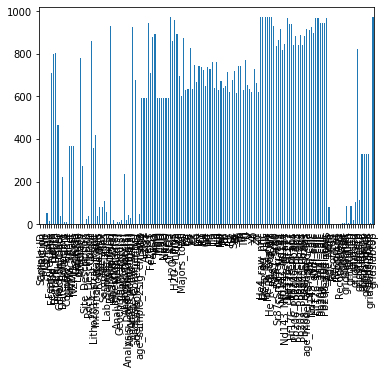

In [210]:
#How many NaNs per feature?
#More NaNs means it will be harder (re-useless) to use in the ML

vc_nulls = df.apply(lambda x: x.isnull().value_counts()).T[True]
#vc_nulls.hist() # if you want a histogram of these counts
## or if you wanted to plot the null count of each column as a bar
vc_nulls.plot(kind = 'bar')

In [198]:
#Set the list of parameter variable names we will use
#Drop gridserp because of too many nans.
#Keep Sample_ID as "random" varibale to benchmark against
#'Hf','Nd','Nd143_Nd144','Hf176_Hf177','Pb207_Pb204','CO2'
sigvars=['Sample_ID','Hf176_Hf177',
         'gridage', 'gridcrust', 'gridsubcrust', 'gridlith', 'gridsublith', 'gridsed', 'gridsubsed', 'gridsubserp',
        'gridslabtop','gridslabage','gridslabdip','gridslabthick','gridslabvel','gridslabsubage']
catvars=['Plot_unit','Rock_Types','Age_Min','Age_Max']

In [200]:
#Make new datasets based on the selected parameters

#dfsub=df[sigvars+catvars].copy()
dfsub=df[sigvars].copy()
#dfnegsub=dfneg[sigvars+catvars].copy()
dfnegsub=dfneg[sigvars].copy()

In [203]:
#Set the sample_id column as a random number to use as a benchmark in feature importantance
#Probably best if the number of random options mathches the number of target categories.
dfsub['Sample_ID'] = np.random.choice([1,2,3,4,5], size=len(dfsub))

#dfsub['Sample_ID'] = np.random.choice([-1,1], size=len(dfsub))
#dfnegsub['Sample_ID'] = np.random.choice([-1,1], size=len(dfnegsub))

In [204]:
dfsub

,Sample_ID,Hf176_Hf177,gridage,gridcrust,gridsubcrust,gridlith,gridsublith,gridsed,gridsubsed,gridsubserp,gridslabtop,gridslabage,gridslabdip,gridslabthick,gridslabvel,gridslabsubage
0,5,NaN,27.215429,0.000006,NaN,0.000004,NaN,0.000046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.414402
1,5,NaN,105.411903,0.000009,0.000069,0.000004,0.000041,0.000006,0.000039,0.000718,NaN,32.78672,22.01977,225093.375,0.000875,26.285441
2,5,NaN,27.176504,0.000006,0.000018,0.000004,0.000008,0.000046,0.000005,0.000003,NaN,NaN,NaN,NaN,NaN,25.345132
3,1,NaN,121.650185,0.000009,0.000026,0.000004,0.000018,0.000129,0.000072,0.000003,NaN,NaN,NaN,NaN,NaN,39.000000
4,2,NaN,121.650185,0.000009,0.000026,0.000004,0.000018,0.000129,0.000072,0.000003,NaN,NaN,NaN,NaN,NaN,39.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
968,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
969,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
970,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [205]:
#Create the the 'target classification vector'

#targets=pd.qcut(dfsub.CO2,5,labels=False)
#targets=pd.qcut(dfsub.Hf,5,labels=False)
#targets=pd.qcut(dfsub.Hf176_Hf177,5,labels=False)
#targets=pd.qcut(dfsub.Nd,5,labels=False)
#targets=pd.qcut(dfsub.Nd143_Nd144,5,labels=False)
#targets=pd.qcut(dfsub.Pb207_Pb204,5,labels=False)

#Merge the two datasets and save it out for exploration Matlab's Classification learner
#Add a column specifying whether this is a genuine volcanic eruption event, or one of our randomised/background noise samples.
#dfsub['vol']=1
#dfnegsub['vol']=-1
#targets = mldata['vol']

In [206]:
#For chemistry targets
mldata=dfsub
mldata['vol']=targets

#For eruption events targets.
#mldata = pd.concat([dfsub, dfnegsub], ignore_index=True, sort=False)




In [ ]:
#Save out the ML dataset to be used later
# mldata.to_csv("mldata_CO2.csv",index=False)
# mldata.to_csv("mldata_Hf.csv",index=False)
mldata.to_csv("mldata_Hf176_Hf177.csv",index=False)
# mldata.to_csv("mldata_Nd.csv",index=False)
# mldata.to_csv("mldata_Nd143_Nd144.csv",index=False)
# mldata.to_csv("mldata_Pb207_Pb204.csv",index=False)

# mldata.to_csv("mldata_negage.csv",index=False)
# mldata.to_csv("mldata_negloc.csv",index=False)

<Figure size 2592x2592 with 0 Axes>

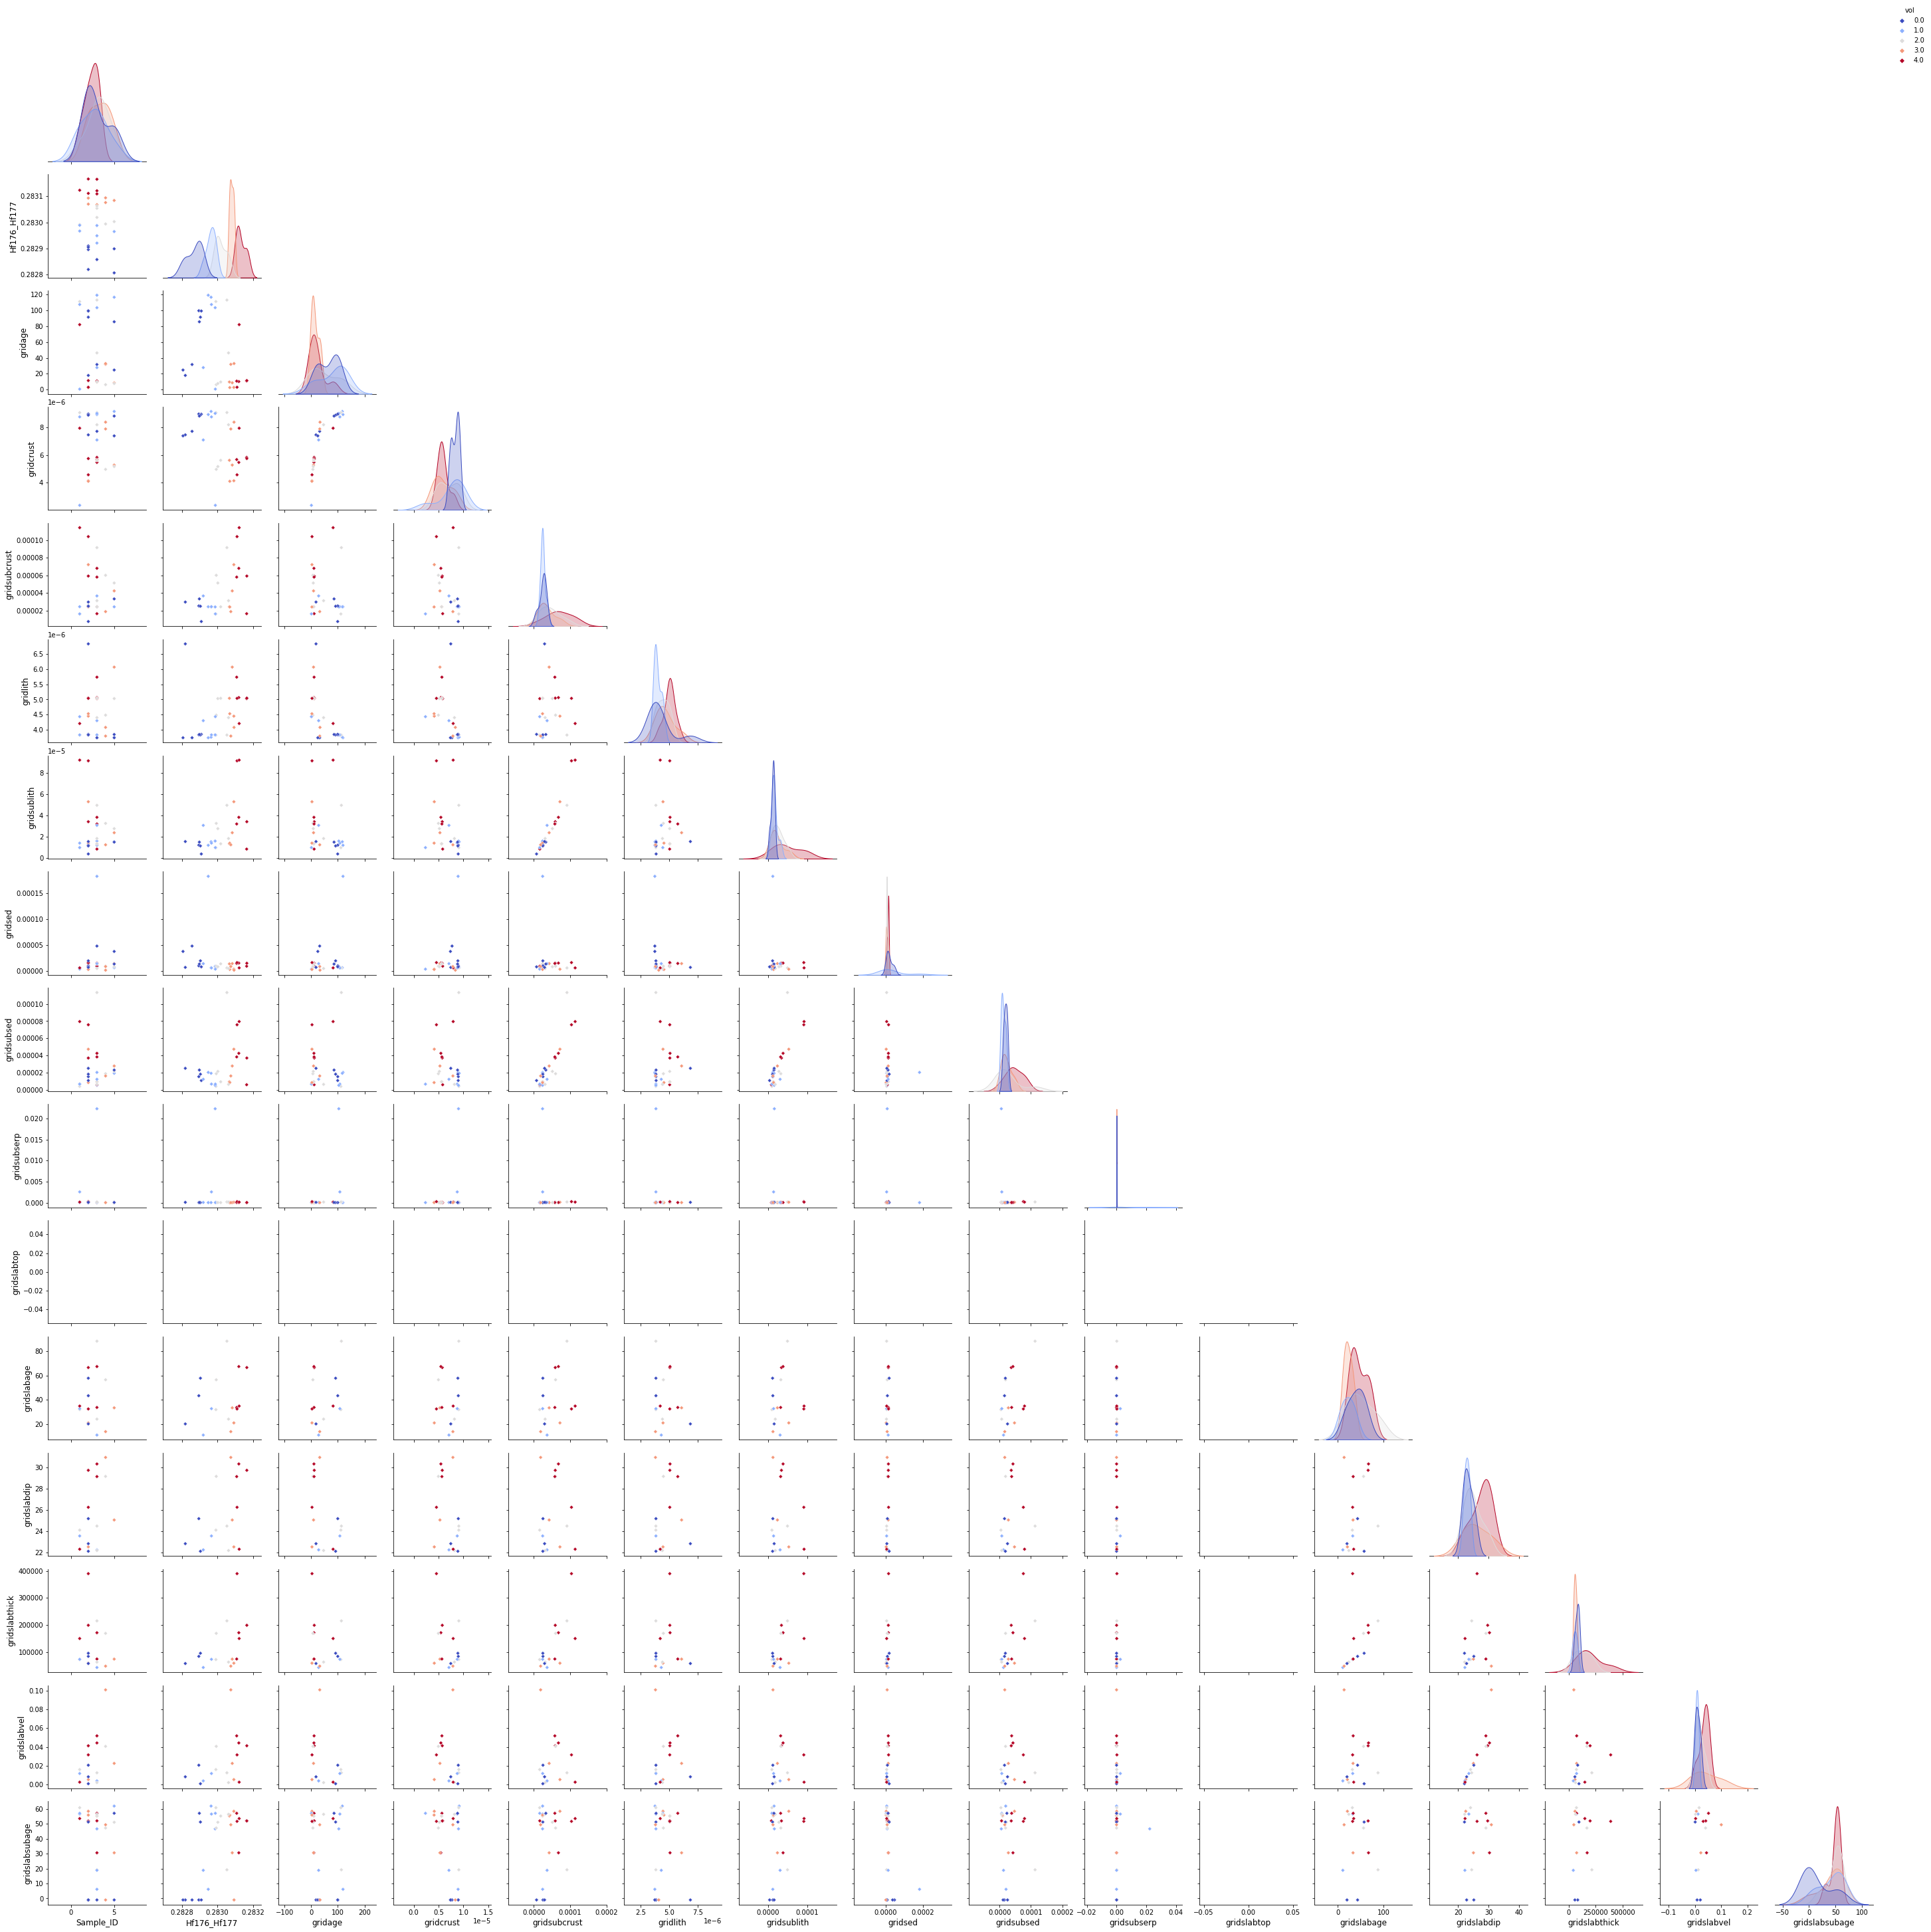

In [208]:
#Plot the variables
plt.figure(figsize=(36, 36))
cols_to_plot = mldata.columns.tolist()
sns.pairplot(mldata[cols_to_plot[:]],  hue ="vol",palette="coolwarm",corner=True)
plt.show()